In [1]:
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [2]:
import pcl

In [3]:
p = pcl.load("../python-pcl/examples/pcldata/tutorials/table_scene_lms400.pcd")

python-pclのビジュアライザがよくわからないので、結局open3Dを使う。

In [4]:
from open3d import *

def get_img(pcd):
    vis = Visualizer()
    vis.create_window(width=640,height=480)
    #vis.get_render_option().load_from_json(RENDER_JSON_FILE)
    for p in pcd:
        vis.add_geometry(p)
    img=vis.capture_screen_float_buffer(True)
    vis.destroy_window()
    return img

def pcl2open3d(pcl_pcd):
    pcd= PointCloud() # open3d pointcloud
    pcd.points = Vector3dVector(pcl_pcd.to_array())
    return pcd

def pcl_viewer(pcl_pcd):
    pcd = pcl2open3d(pcl_pcd)
    draw_geometries([pcd],width=640,height=480)

def pcl_get_img(pcl_pcd):
    pcd = pcl2open3d(pcl_pcd)
    return get_img([pcd])


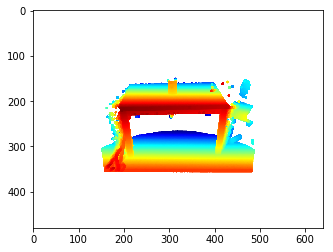

In [5]:
img=pcl_get_img(p)
plt.imshow(img)

やりたかったのはセグメンテーションとか認識とかなので、そこだけやる。まずセグメンテーションから。
平面とか、幾何図形のはできそう。

In [6]:
seg = p.make_segmenter()
seg.set_model_type(pcl.SACMODEL_PLANE)
seg.set_method_type(pcl.SAC_RANSAC)
seg.set_distance_threshold(0.01)
indices, model = seg.segment()

In [7]:
p_plane= PointCloud() 
p_plane.points = Vector3dVector(p.to_array()[indices])

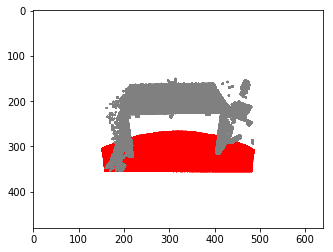

In [8]:
# open3dのPointCloudに変換
p3=pcl2open3d(p)

# もとの点群から見つけた平面（近傍の点)を削除する
p3.points = Vector3dVector(np.delete(p3.points , indices,axis=0))

# ダウンサンプル（高速化のため）
p3=voxel_down_sample(p3, voxel_size = 0.01) 

# 見つけた平面を赤、それ以外をグレイで塗る
p3.paint_uniform_color([0.5,0.5,0.5])
p_plane.paint_uniform_color([1,0,0])

# 表示
plt.imshow(get_img([p3,p_plane]))

複数平面を見つけるには、見つかった平面を消してまた探索、を繰り返せばいい。[こちら](http://pointclouds.org/documentation/tutorials/extract_indices.php#extract-indices)を参考にした。

3


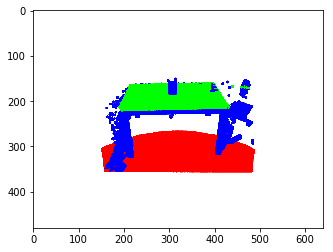

In [9]:
p0=p
org_size=p.size

points=[]
while(p0.size>0.3*org_size):
    seg = p0.make_segmenter()
    seg.set_model_type(pcl.SACMODEL_PLANE)
    seg.set_method_type(pcl.SAC_RANSAC)
    seg.set_distance_threshold(0.01)
    indices, model = seg.segment()
    points.append(pcl2open3d(p0.extract(indices))) # Indicesの指す点をOpen3D形式にして保存。
    p0=p0.extract(indices,negative=True) # indicesの指す点を削除。わかりにくい。。

points.append(pcl2open3d(p0))
print(len(points))

colors=[[1,0,0],[0,1,0],[0,0,1],[1,1,0],[0,1,1],[1,0,1]]
for i,p_plane in enumerate(points):
    p_plane.paint_uniform_color(colors[i%len(colors)])
plt.imshow(get_img(points))

In [10]:
#draw_geometries(points,width=640,height=480)

あれ、MinCutSegmentationは未実装か。。

## フィルタ

In [11]:
fil = p.make_statistical_outlier_filter()
fil.set_mean_k(50)
fil.set_std_dev_mul_thresh(1.0)

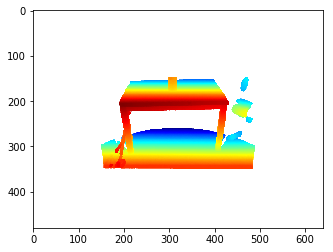

In [12]:
plt.imshow(pcl_get_img(fil.filter()))

外れ値が消されてすっきり。

## キーポイント検出
Harrisだけがpython実装されてる。[x,y,z,intensity]で返されるらしいのでintensityでソートして上位何点かをとればよいか。

In [13]:
#p = pcl.load("../python-pcl/examples/pcldata/tutorials/lamppost.pcd")
p=pcl.load("../Open3D/build361/lib/TestData/feature/cloud_bin_0.pcd")

p3=pcl2open3d(p)
kp=p.make_HarrisKeypoint3D()
kp.set_NonMaxSupression(True)
kp.set_Radius(0.1)
keypoints =kp.compute()

In [14]:
kpa=keypoints.to_array()
#print(np.shape(kpa))
kp_xyz=kpa[:,0:3]
intensity = kpa[:,3]
#kp_xyz=kp_xyz[np.argsort(intensity)[::-1],:][:100] # 上位100ポイント
kp_pcd= PointCloud()
kp_pcd.points = Vector3dVector(kp_xyz)

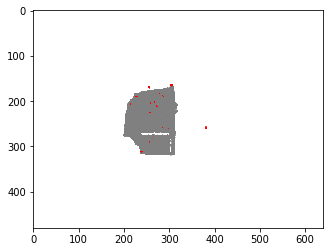

In [15]:
p3.paint_uniform_color([0.5,0.5,0.5])
kp_pcd.paint_uniform_color([1,0,0])
plt.imshow(get_img([p3,kp_pcd]))

うーん。